In [1]:
#!/usr/bin/env python
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.driver as cuda
import pycuda.gpuarray as gpuarray
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [26]:
class Convolution:
	def __init__(self):
		# """
		# Attributes for instance of EncoderDecoder module
		# """
		self.mod = None
		self.getSourceModule()
		self.tile_size = 12
		self.mask_size = 5
		self.block_size = self.tile_size + self.mask_size -1
		self.block_dim = (self.block_size, self.block_size, 1)
	
	def getSourceModule(self):
		# kernel code wrapper
		kernelwrapper = """
			#include <stdio.h>

			//****************************************************************************************
			// global memory function

			__global__ 
			void conv_gpu_naive(float *N, float *P, float *M, int height, int width, int mask_width){

				// the coordinate of thread (also coordinate in N or P)
				int col = blockDim.x * blockIdx.x + threadIdx.x;
				int row = blockDim.y * blockIdx.y + threadIdx.y;

				// copy to register
				int mask_w = mask_width;
				int n_w = width;
				int n_h = height;
				// start point of the kernel
				int col_start = col - mask_w/2;
				int row_start = row - mask_w/2;

				float p_value = 0.0f;

				// see if the thread in the range of N
				if((row<n_h)&&(col<n_w)){

					for(int i=0; i<mask_w; i++){			// in y direction of mask

						int row_mask = mask_w - 1 - i;		// x coordinate in mask
						int row_n = row_start + i;			// x coordinate in N
						
						for(int j=0; j<mask_w; j++){		// in x direction of mask

							int col_mask = mask_w - 1 - j;	// y coordinate in mask
							int col_n = col_start + j;		// y coordinate in N

							// if in the range of N
							if ((col_n>=0) && (col_n<n_w) && (row_n>=0) && (row_n<n_h)){
								p_value += N[row_n*n_w+col_n] * M[row_mask*mask_w+col_mask];
							}
						}
					}
					P[row*n_w+col] = p_value;
				}
			}

			//****************************************************************************************

			// predefined parameters
			#define MASK_SIZE 5
			#define TILE_SIZE 12
			#define TILE_SIZE_PAD (TILE_SIZE + MASK_SIZE - 1)

			//****************************************************************************************
			// shared memory function

			__global__
			void conv_gpu_shared_mem(float *N, float *P, float *M, int height, int width){

				// copy to register
				const int n_w = width;
				const int n_h = height;
				const int mask_size = MASK_SIZE;
				const int tile_size = TILE_SIZE;

				__shared__ float N_ds[TILE_SIZE_PAD][TILE_SIZE_PAD];	// copy part of input matrix into shared memory
				__shared__ float M_ds[MASK_SIZE][MASK_SIZE];			// copy mask into shared memory

				// current position of N_ds
				const int tx = threadIdx.x;
				const int ty = threadIdx.y;

				// current position of input matrix
				const int col = tx + blockIdx.x*tile_size;
				const int row = ty + blockIdx.y*tile_size;

				// start point of mask
				const int col_start = col - mask_size/2;
				const int row_start = row - mask_size/2;

				// copy mask to shared memory
				for(int i=0; i<mask_size; i++){				// in x direction of mask
					for(int j=0; j<mask_size; j++){			// in y direction of mask
						M_ds[i][j] = M[i*mask_size+j];
					}
				}

				// copy input matrix to shared memory by tile (each thread will copy 1 element to N_ds)
				// here each tile is enlarged to TILE_SIZE_PAD which is size of N_ds and block

				if((row_start>=0) && (row_start<n_h) && (col_start>=0) && (col_start<n_w)){
					N_ds[ty][tx] = N[row_start*n_w+col_start];
				}
				else{
					N_ds[ty][tx] = 0.0f;
				}

				// need to wait all the thread have done copy
				__syncthreads();

				float p_value = 0.0f;
				if((ty<tile_size) && (tx<tile_size)){			// in range of tile

					// in y direction of mask
					for(int i=0; i<mask_size; i++){
						int row_n = ty+i;						// y coordinate in N_ds
						int row_mask = mask_size - 1 - i;		// y coordinate in mask

						// in x direction of mask
						for(int j=0; j<mask_size; j++){
							int col_n = tx+j;					// x coordinate in N_ds
							int col_mask = mask_size - 1 - j;	// x coordinate in mask
							p_value += N_ds[row_n][col_n] * M_ds[row_mask][col_mask];
						}
					}
					if((row<n_h) && (col<n_w)){					// in range of input matrix
						P[row*n_w+col] = p_value;
					}
				}
			}

			//****************************************************************************************

			// allocate constant memory for mask
			__constant__ float M_c[MASK_SIZE*MASK_SIZE];

			//****************************************************************************************
			// shared + constant memory function

			__global__ 
			void conv_gpu_shared_and_constant_mem(float *N, float *P, float *M_c, int height, int width){
				
				// copy to register
				const int n_w = width;
				const int n_h = height;

				__shared__ float N_ds[TILE_SIZE_PAD][TILE_SIZE_PAD];	// copy part of input matrix into shared memory

				// current position of N_ds
				const int tx = threadIdx.x;
				const int ty = threadIdx.y;

				// current position of input matrix
				const int col = tx + blockIdx.x*TILE_SIZE;
				const int row = ty + blockIdx.y*TILE_SIZE;

				// start point of mask
				const int col_start = col - MASK_SIZE/2;
				const int row_start = row - MASK_SIZE/2;

				// mask is in the constant memory

				// copy input matrix to shared memory by tile (each thread will copy 1 element to N_ds)
				// here each tile is enlarged to TILE_SIZE_PAD which is size of N_ds and block

				if((row_start>=0) && (row_start<n_h) && (col_start>=0) && (col_start<n_w)){
					N_ds[ty][tx] = N[row_start*n_w+col_start];
				}
				else{
					N_ds[ty][tx] = 0.0f;
				}

				// need to wait all the thread have done copy
				__syncthreads();

				float p_value = 0.0f;
				if((ty<TILE_SIZE) && (tx<TILE_SIZE)){			// in range of tile

					// in y direction of mask
					for(int i=0; i<MASK_SIZE; i++){
						int row_n = ty+i;						// y coordinate in N_ds
						int row_mask = MASK_SIZE - 1 - i;		// y coordinate in mask

						// in x direction of mask
						for(int j=0; j<MASK_SIZE; j++){
							int col_n = tx+j;					// x coordinate in N_ds
							int col_mask = MASK_SIZE - 1 - j;	// x coordinate in mask
							p_value += N_ds[row_n][col_n] * M_c[row_mask*MASK_SIZE+col_mask];
						}
					}
					if((row<n_h) && (col<n_w)){					// in range of input matrix
						P[row*n_w+col] = p_value;
					}
				}
			}


		
		""" # you can either use a string or save the kernel in kernel.cu file and reference it here.
		# Compile the kernel code when an instance
		# of this class is made. 
		mod = SourceModule(kernelwrapper)
			
		self.mod = mod


	def getGridDim(self, height, width, dim_h, dim_w):
		GridDim = (height//dim_h+1, width//dim_w+1,1)
		return GridDim

	def conv_gpu_naive(self, N, M):
		"""
		parallel convolution using global memory
		visit input matrix and mask from global memory in the kernel
		mask can be any size

		params:
		- N: input matrix
		- M: mask

		return:
		- P: result
		- time
		"""
		# implement this, note you can change the function signature (arguments and return type)
		# start = cuda.Event()
		# end = cuda.Event()
		# start.record()

		# get shape of input matrix
		height, width = N.shape
		# get shape of mask
		mask_width = M.shape[0]
		# create the result matrix
		P = np.empty_like(N)

		start = cuda.Event()
		end = cuda.Event()
		start.record()

		# memory allocation on device
		# N_d = gpuarray.to_gpu(N)
		# M_d = gpuarray.to_gpu(M)
		# P_d = gpuarray.to_gpu(P)
		N_d = cuda.mem_alloc_like(N)
		M_d = cuda.mem_alloc_like(M)
		P_d = cuda.mem_alloc_like(P)

		# copy matrics to device
		cuda.memcpy_htod(M_d, M)
		cuda.memcpy_htod(N_d, N)

		# block and grid size
		blockdim = 32
		BlockDim = (blockdim, blockdim, 1)
		GridDim = self.getGridDim(height, width, dim_h=blockdim, dim_w=blockdim)

		func_conv = self.mod.get_function("conv_gpu_naive")
		func_conv(N_d, P_d, M_d, np.int32(height), np.int32(width), np.int32(mask_width), block=BlockDim, grid = GridDim)

		cuda.memcpy_dtoh(P, P_d)
		
		end.record()
		end.synchronize()
		time = start.time_till(end)

		return P, time

	def conv_gpu_shared_mem(self, N, M):
		"""
		parallel convolution using shared memory
		visit input matrix and mask from shared memory in the kernel
		mask have to be 5*5

		params:
		- N: input matrix
		- M: mask

		return:
		- P: result
		- time
		"""
		# start = cuda.Event()
		# end = cuda.Event()
		# start.record()

		# get shape of input matrix
		height, width = N.shape

		P = np.empty_like(N)

		start = cuda.Event()
		end = cuda.Event()
		start.record()

		# memory allocation on device
		N_d = cuda.mem_alloc_like(N)
		M_d = cuda.mem_alloc_like(M)
		P_d = cuda.mem_alloc_like(P)

		# copy matrics to device
		cuda.memcpy_htod(M_d, M)
		cuda.memcpy_htod(N_d, N)

		# block and grid size
		BlockDim = self.block_dim
		GridDim = self.getGridDim(height, width, dim_h=self.tile_size, dim_w=self.tile_size)

		func_conv = self.mod.get_function("conv_gpu_shared_mem")
		func_conv(N_d, P_d, M_d, np.int32(height), np.int32(width), np.int32(self.tile_size), block=BlockDim, grid = GridDim)

		cuda.memcpy_dtoh(P, P_d)

		end.record()
		end.synchronize()
		time = start.time_till(end)

		return P, time

	def conv_gpu_shared_and_constant_mem(self, N, M):
		"""
		parallel convolution using shared memory and constant memory
		visit input matrix from shared memory, visit mask from constant memory in the kernel
		mask have to be 5*5

		params:
		- N: input matrix
		- M: mask

		return:
		- P: result
		- time
		"""

		# start = cuda.Event()
		# end = cuda.Event()
		# start.record()

		# get shape of input matrix
		height, width = N.shape

		P = np.empty_like(N)

		start = cuda.Event()
		end = cuda.Event()
		start.record()
		# memory allocation on device
		N_d = cuda.mem_alloc_like(N)
		M_d = cuda.mem_alloc_like(M)
		P_d = cuda.mem_alloc_like(P)

		# copy matrics to device
		cuda.memcpy_htod(M_d, M)
		cuda.memcpy_htod(N_d, N)

		# block and grid size
		BlockDim = self.block_dim
		GridDim = self.getGridDim(height, width, dim_h=self.tile_size, dim_w=self.tile_size)

		func_conv = self.mod.get_function("conv_gpu_shared_and_constant_mem")
		func_conv(N_d, P_d, M_d, np.int32(height), np.int32(width), np.int32(self.tile_size), block=BlockDim, grid = GridDim)

		cuda.memcpy_dtoh(P, P_d)

		end.record()
		end.synchronize()
		time = start.time_till(end)

		return P, time

	@staticmethod
	def conv_scipy(N, M):
		"""
		Serial convolution using scipy.signal.convolve2d

		params:
		- N: input matrix
		- M: mask

		return:
		- P: result
		- time
		"""
		start = time.time()

		P = convolve2d(N.astype(np.float32), M.astype(np.float32), mode='same')

		return P, (time.time()-start)*1000


	def test_conv_pycuda(self, N_size):
		"""
		test the correctness and performance of the parallel function

		params:
		- N_size: size of the input matrix, N is quare

		return:
		- t_naive: time of naive function
		- t_sh:    time of shared memory function 
		- t_const: time of shared and constant function
		- t_scipy: tmie of scipy function
		"""

		N = np.random.rand(N_size,N_size).astype(np.float32)
		M = np.random.rand(self.mask_size,self.mask_size).astype(np.float32)

		P_cu_naive, t_naive = self.conv_gpu_naive(N,M)
		P_cu_sh, t_sh = self.conv_gpu_shared_mem(N,M)
		P_cu_const, t_const = self.conv_gpu_shared_and_constant_mem(N,M)
		P_sp, t_scipy = self.conv_scipy(N,M)
 
		if not np.allclose(P_cu_naive, P_sp):
			raise Exception('Result from method using global memory does not match the correct answer!',
			'The shape of input matrix is %d' % (N_size))
		if not np.allclose(P_cu_sh, P_sp):
			raise Exception('Result from method using shared memory does not match the correct answer!',
			'The shape of input matrix is %d' % (N_size))
		if not np.allclose(P_cu_const, P_sp):
			raise Exception('Result from method using shared and constant memory does not match the correct answer!',
			'The shape of input matrix is %d' % (N_size))

		return t_naive, t_sh, t_const, t_scipy


In [27]:

conver = Convolution()

time_hist = []

test_num_list = [16, 64, 256, 1024, 4096]

for n_size in test_num_list:
    time_hist_temp = []
    for _ in range(10):
        time_hist_temp.append(conver.test_conv_pycuda(n_size))
    #     print(time_hist_temp)
    # print(np.array(time_hist_temp))
    time_hist.append(np.mean(np.array(time_hist_temp), axis=0))
    # print(time_hist)

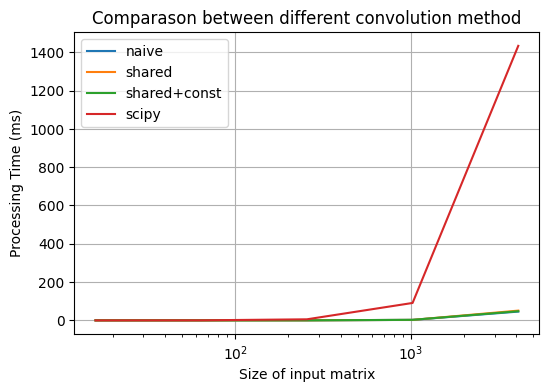

In [38]:
time_hist = np.array(time_hist)
plt.figure(dpi=100)

plt.grid()
plt.plot(test_num_list, time_hist[:,0], label='naive')
plt.plot(test_num_list, time_hist[:,1], label='shared')
plt.plot(test_num_list, time_hist[:,2], label='shared+const')
plt.plot(test_num_list, time_hist[:,3], label='scipy')
plt.semilogx()
plt.ylabel('Processing Time (ms)')
plt.xlabel('Size of input matrix')
plt.title('Comparason between different convolution method')
plt.legend();



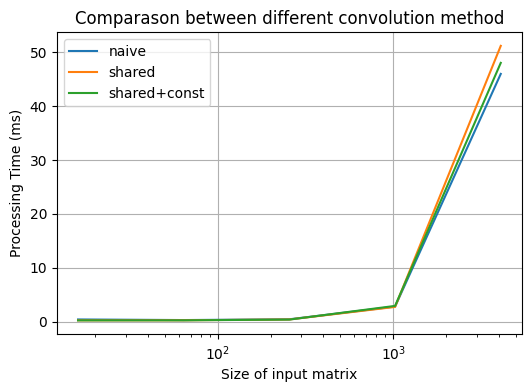

In [39]:
plt.figure(dpi=100)

plt.grid()
# plt.plot(range(len(test_num_list)), time_hist[:,0], label='naive')
# plt.plot(range(len(test_num_list)), time_hist[:,1], label='shared')
# plt.plot(range(len(test_num_list)), time_hist[:,2], label='shared+const')
plt.plot(test_num_list, time_hist[:,0], label='naive')
plt.plot(test_num_list, time_hist[:,1], label='shared')
plt.plot(test_num_list, time_hist[:,2], label='shared+const')
# plt.semilogy()
plt.semilogx()
plt.ylabel('Processing Time (ms)')
plt.xlabel('Size of input matrix')
plt.title('Comparason between different convolution method')
plt.legend();

In [16]:
time_hist = np.array(time_hist)
print(time_hist.shape)

print(time_hist)

(5, 4)
[[1.82944002e+00 2.83641601e-01 2.71788797e-01 6.33001328e-02]
 [3.15468800e-01 2.75129603e-01 2.69555199e-01 5.07187843e-01]
 [4.16963199e-01 3.87878400e-01 3.72815996e-01 5.65660000e+00]
 [2.62805119e+00 4.22047353e+00 4.15957441e+00 8.99134636e+01]
 [4.59731678e+01 5.09122398e+01 4.77796352e+01 1.46947379e+03]]


In [12]:
"""
for(int i=0; i<mask_w; i++){
    // x coordinate in mask
    int row_mask = mask_w - 1 - i
    // x coordinate in N
    int row_n = row_start + i;

    for(int j=0; j<mask_w; j++){
        // y coordinate in mask
        int col_mask = mask_w - 1 - j
        // y coordinate in N
        int col_n = col_start + j;

        // if in the range of N
        if(col_n>=0 && col_n<n_w && row_n>=0 && row_n<n_h ){
            p_value += N[row_n*n_w+col_n] * M[row_mask*mask_w+col_mask];
        }
    }
    
}
"""
mask_w = 5
height, width = 20,30
row, col = 10,20
row_n_start = row - mask_w//2
col_n_start = col - mask_w//2
for i in range(mask_w):
    row_mask = mask_w - 1 - i
    row_n = row_n_start + i
    for j in range(mask_w):
        col_mask = mask_w - 1 - j
        col_n = col_n_start + j
        if (row_n>=0) & (row_n<height) & (col_n>=0) & (col_n<width):
            # print(row_n,'  ', col_n, '  ', row_mask, '  ', col_mask)
            print("(", row_n, ',', col_n, ')', '  ', row_n*width+col_n, '  ', row_mask*mask_w+col_mask)
    print('\n')




( 8 , 18 )    258    24
( 8 , 19 )    259    23
( 8 , 20 )    260    22
( 8 , 21 )    261    21
( 8 , 22 )    262    20


( 9 , 18 )    288    19
( 9 , 19 )    289    18
( 9 , 20 )    290    17
( 9 , 21 )    291    16
( 9 , 22 )    292    15


( 10 , 18 )    318    14
( 10 , 19 )    319    13
( 10 , 20 )    320    12
( 10 , 21 )    321    11
( 10 , 22 )    322    10


( 11 , 18 )    348    9
( 11 , 19 )    349    8
( 11 , 20 )    350    7
( 11 , 21 )    351    6
( 11 , 22 )    352    5


( 12 , 18 )    378    4
( 12 , 19 )    379    3
( 12 , 20 )    380    2
( 12 , 21 )    381    1
( 12 , 22 )    382    0




In [13]:
N = np.random.rand(5,6)
height, width = N.shape
print(height, width)
BlockDim = (*N.shape,1)
print(BlockDim)
M = np.array(([0,0,0],[0,1,0],[0,0,0]))
print(M)

5 6
(5, 6, 1)
[[0 0 0]
 [0 1 0]
 [0 0 0]]


In [11]:
import numpy as np

import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# DEVICE SETUP
BLOCK_SIZE = 32  # Max 32. 32**2 = 1024, max for GTX1060

def getSourceModule():
    kernel = """
    __global__ 
    void conv(const float *A, const float *B, int aw, int ah, int bw, int bh, int b_sum, float *C){

        /*Get row and column to operate on from thread coordinates*/
        int tx = threadIdx.x;
        int ty = threadIdx.y;
        
        int bx = blockIdx.x;
        int by = blockIdx.y;
        
        int row = by*blockDim.y + ty;
        int col = bx*blockDim.x + tx;
        
        /*Calculate "padding" radius of convolution kernel (distance around central pixel)*/
        int pw = (bw-1)/2;
        int ph = (bh-1)/2;

        /*If within the range of C (ie A - padding)*/
        if( row < (ah-2*ph) && col < (aw-2*pw) ) {
            
            /*Set initial pixel value*/
            int val = 0;
            
            /*For each vertical position on the kernel matrix, relative to the central pixel*/
            for(int i=-ph; i<=ph; i=i+1){
                /*Calculate zero-indexed row ID on kernel matrix*/
                int b_row = i+ph; 

                /*For each horizontal position on the kernel matrix, relative to the central pixel*/
                for(int j=-pw; j<=pw; j=j+1){
                    /*Calculate zero-indexed column ID on kernel matrix*/
                    int b_col = j+pw;

                    /*Add product of kernel value and corresponding image value to running total*/
                    val += A[ (row+ph +i)*aw + (col+pw +j) ] * B[ b_row*bw + b_col ];
                }
            }
            
            /*Copy appropriately normalised resulting pixel value to position on C matrix*/
            C[row*(aw-2*pw) + col] = val/b_sum;
        }
    }
    """
    return SourceModule(kernel)
    
# Compile kernel
mod = getSourceModule()

# Get functions
conv = mod.get_function("conv")




def convolve(a, b):
    global BLOCK_SIZE
    global conv
    
    a, b = [np.array(i).astype(np.float32) for i in [a, b]]
    
    # Matrix A 
    aw = np.int32(a.shape[1])  # Widthof in matrix
    ah = np.int32(a.shape[0])  # Height of in matrix
    
    # Matrix B (kernel)
    bw = np.int32(b.shape[1])  # Widthof in matrix
    if bw % 2 == 0:
        print("Kernel width is not an odd number! Strange things will happen...")
    bh = np.int32(b.shape[0])  # Height of in matrix
    if bh % 2 == 0:
        print("Kernel height is not an odd number! Strange things will happen...")
    b_sum = np.int32(np.absolute(b).sum())
    
    # Matrix C, subtract 2*padding, *2 because it's taken off all sides
    c = np.empty([ah-(bh-1), aw-(bw-1)])
    c = c.astype(np.float32)
    
    # Allocate memory on device
    a_gpu = cuda.mem_alloc(a.nbytes)
    b_gpu = cuda.mem_alloc(b.nbytes)
    c_gpu = cuda.mem_alloc(c.nbytes)
    
    # Copy matrix to memory
    cuda.memcpy_htod(a_gpu, a)
    cuda.memcpy_htod(b_gpu, b)

    # Set grid size from A matrix
    grid = (int(aw/BLOCK_SIZE+(0 if aw % BLOCK_SIZE is 0 else 1)), 
            int(ah/BLOCK_SIZE+(0 if ah % BLOCK_SIZE is 0 else 1)), 
                          1)
    
    # Call gpu function
    conv(a_gpu, b_gpu, aw, ah, bw, bh, b_sum, c_gpu, block=(BLOCK_SIZE, BLOCK_SIZE, 1), grid=grid)
    
    # Copy back the result
    cuda.memcpy_dtoh(c, c_gpu)
    
    # Free memory. May not be useful? Ask about this.
    a_gpu.free()
    b_gpu.free()
    c_gpu.free()
    
    # Return the result
    return c

In [16]:
N = np.random.rand(30,40)*10
M = np.random.rand(3,3)*10
# M = np.array([[1,0,0],[0,0,0],[0,0,0]])
# print(M)
P_cu = convolve(N,M)
# P_sp = convolve2d(N.astype(np.float32), M.astype(np.float32), mode='full')
# print(np.allclose(P_cu, P_sp))
print(N,'\n')
print(P_cu,'\n')
# print(P_sp)

[[6.23089391 0.12648244 9.84181206 ... 4.38169318 9.23371247 8.44490616]
 [9.0537361  1.22756095 1.12970777 ... 1.99929716 8.66201555 1.32353132]
 [2.44116335 6.99184915 3.61355678 ... 8.37585567 1.13886745 2.69067491]
 ...
 [0.43791003 3.87850462 1.00171959 ... 4.45572115 3.38204623 7.43212451]
 [1.80912737 0.2074232  5.94952211 ... 9.50651707 7.78914735 1.64754239]
 [1.48632327 3.8389076  7.07190159 ... 5.33207501 1.98681875 7.21444586]] 

[[3. 3. 5. ... 5. 4. 4.]
 [3. 4. 4. ... 4. 6. 4.]
 [2. 3. 3. ... 5. 6. 5.]
 ...
 [4. 5. 5. ... 5. 5. 5.]
 [3. 4. 4. ... 5. 5. 5.]
 [2. 3. 5. ... 4. 5. 6.]] 

